# Kernel on Graphs Project
### MVA Master
### Yannis Cattan, Eugène Berta

In [1]:
import cvxopt
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from utils import (
    KernelSVC,
    WL_features,
    WLK_linear,
    WLK_l2_norm,
    clean_dataset,
    nth_order_walk,
    get_all_atom_types,
    stratified_cross_val,
)

cvxopt.solvers.options['show_progress'] = False

Reading the data:

In [2]:
with open('data/training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)

with open('data/test_data.pkl', 'rb') as file:
    test_graphs = pkl.load(file)

with open('data/training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

Plotting a graph in the original dataset:

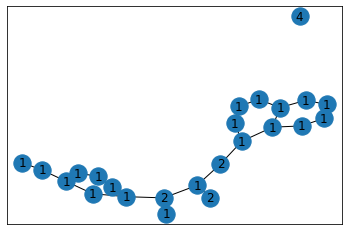

In [3]:
idx=1
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

Cleaning the data:

In [4]:
train_graphs, train_labels = clean_dataset(train_graphs, train_labels)
test_graphs, _ = clean_dataset(test_graphs, np.zeros(2000), discard=False)

Plotting a graph in the cleaned dataset:

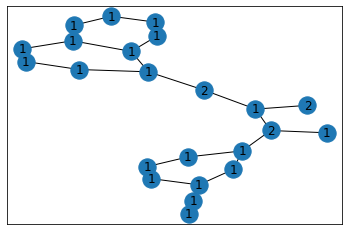

In [5]:
idx=1
nx.draw_networkx(train_graphs[idx], labels=get_all_atom_types(train_graphs[idx]))

The outlier atom was succesfully removed !

## 1. Building the Gram Matrix

### Walk kernel Gram Matrix:

In [6]:
# n = 3

# N_train = len(train_graphs)
# indexes_train = np.arange(N_train)

# N_test = len(test_graphs)
# indexes_test = np.arange(N_test)

# G_train = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         g = nth_order_walk(train_graphs[i], train_graphs[j])
#         G_train[i,j] = g
#         G_train[j,i] = g

### Weisfeiler Lehman (WL) Gram Matrix:

Explicit features computation:

In [7]:
h = 2

N_train = len(train_graphs)
indexes_train = np.arange(N_train)

N_test = len(test_graphs)
indexes_test = np.arange(N_test)

X_train = []
for i in indexes_train:
    X_train.append(WL_features(train_graphs[i], max_iter=h))

X_test = []
for i in indexes_test:
    X_test.append(WL_features(test_graphs[i], max_iter=h))

#### Linear Kernel:

In [8]:
# G_train_lin = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         g = WLK_linear(X_train[i], X_train[j])
#         G_train_lin[i,j] = g
#         G_train_lin[j,i] = g

In [9]:
# # Matrix normalization:
# Norm = np.zeros((N_train, N_train))
# for i in tqdm(range(N_train)):
#     for j in range(i, N_train):
#         n = np.sqrt(G_train_lin[i,i]*G_train_lin[j,j])
#         Norm[i,j] = n
#         Norm[j,i] = n

# G_train_lin = np.divide(G_train_lin, Norm)

In [10]:
# G_test_lin = np.zeros((N_test, N_train))
# for i in tqdm(range(N_test)):
#     for j in range(N_train):
#         G_test_lin[i,j] = WLK_linear(X_test[i], X_train[j]) # / np.sqrt(WLK_linear(X_test[i], X_test[i]) * WLK_linear(X_train[j], X_train[j]))

#### RBF Kernel:

L2 norm Matrices:

In [11]:
G_train_dist = np.zeros((N_train, N_train))
for i in tqdm(range(N_train)):
    for j in range(i, N_train):
        G_train_dist[i,j] = WLK_l2_norm(X_train[i], X_train[j])
        G_train_dist[j,i] = G_train_dist[i,j]

100%|██████████| 5774/5774 [04:00<00:00, 24.02it/s] 


In [12]:
G_test_dist = np.zeros((N_test, N_train))
for i in tqdm(range(N_test)):
    for j in range(N_train):
        G_test_dist[i,j] = WLK_l2_norm(X_test[i], X_train[j])

100%|██████████| 2000/2000 [03:09<00:00, 10.54it/s]


RBF Kernel:

In [13]:
sigma = 5.
G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

### Fitting KNN to check for signal in the Gram Matrix

In [14]:
# y_pred = kNN(G_val, y_train, k=1)

# cm = confusion_matrix(y_val, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
# disp.plot()
# plt.show()

# y_pred.sum()/len(y_pred)

## 2. Fitting SVC with Stratified Cross Validation.

Cross validation:

In [15]:
C = 0.5
class_weights={-1:1, 1:5}

models, scores, test_preds = stratified_cross_val(
    n_fold=6,
    G_train=G_train_rbf,
    train_labels=train_labels,
    G_test=G_test_rbf,
    C=C,
    class_weights=class_weights,
    verbose=True,
    seed=42
)
y_test_pred = np.mean(test_preds, axis=0)

print(f'\nMean score: {np.mean(scores)}')

##### 6-FOLD CROSS VAL: starting fold 1 #####
Percentage of positive values: 9.436708%%
Val score: 0.9222703901602983
##### 6-FOLD CROSS VAL: starting fold 2 #####
Percentage of positive values: 9.436708%%
Val score: 0.9114452061699768
##### 6-FOLD CROSS VAL: starting fold 3 #####
Percentage of positive values: 9.436708%%
Val score: 0.9225413348119771
##### 6-FOLD CROSS VAL: starting fold 4 #####
Percentage of positive values: 9.434746%%
Val score: 0.9300349478305849
##### 6-FOLD CROSS VAL: starting fold 5 #####
Percentage of positive values: 9.434746%%
Val score: 0.9317760310871677
##### 6-FOLD CROSS VAL: starting fold 6 #####
Percentage of positive values: 9.453563%%
Val score: 0.8938002296211253

Mean score: 0.9186446899468551


## 3. Grid search on Parameters.

In [16]:
# sigmas = [3., 4., 5., 6., 7.]
# Cs = [0.2, 0.5, 1., 2.]
# class_weights = [{-1:1, 1:1}, {-1:1, 1:5}, {-1:1, 1:10}]

# results = []

# best_score = 0
# y_test_pred = np.zeros(2000)

# for sigma in sigmas:
#     print(f'#### sigma = {sigma} ####')
#     G_train_rbf = np.exp(-0.5*G_train_dist/(sigma**2))
#     G_test_rbf = np.exp(-0.5*G_test_dist/(sigma**2))

#     for C in Cs:
#         for class_weight in class_weights:
#             models, scores, test_preds = stratified_cross_val(
#                 G_train=G_train_rbf,
#                 train_labels=train_labels,
#                 G_test=G_test_rbf,
#                 C=C,
#                 class_weights=class_weight,
#                 seed=42,
#                 verbose=False,
#                 n_fold=6
#             )

#             mean_score = np.mean(scores)

#             parameters = {
#                 'h':3,
#                 'class_weights':class_weight,
#                 'clean_data':True,
#                 'sigma':sigma,
#                 'C':C,
#                 'mean_score':mean_score
#             }

#             results.append(parameters)

#             if mean_score > best_score:
#                 best_score = mean_score
#                 y_test_pred = np.mean(test_preds, axis=0)
#                 print(f'New best model \n   sigma = {sigma}, C = {C}, class_weights = {class_weight} \n   score = {mean_score}')

# y_test_pred = np.mean(test_preds, axis=0)

# dataframe = pd.DataFrame(results)
# dataframe.to_csv('grid_search_results.csv')

Plotting grid search results:

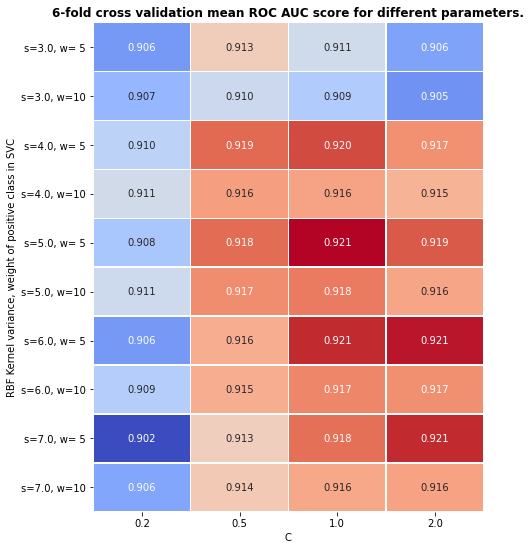

In [17]:
df = pd.read_csv('/home/eugene/code/mva-kernel/grid_search_results.csv')
df = df[df['class_weights'].isin(['{-1: 1, 1: 5}', '{-1: 1, 1: 10}'])]
df['parameters'] = df.apply(lambda x: f's={x.sigma}, w={x.class_weights[-3:-1]}', axis=1)

table = df.pivot("parameters", "C", "mean_score")

f, ax = plt.subplots(figsize=(7, 9))
sns.heatmap(
    table,
    annot=True,
    fmt='.3f',
    linewidths=.5,
    ax=ax,
    cmap='coolwarm',
    cbar=False,
    #cbar_kws={"shrink": 0.8}
)

ax.set_title('6-fold cross validation mean ROC AUC score for different parameters.', weight='bold')
ax.set_xlabel('C')
ax.set_ylabel('RBF Kernel variance, weight of positive class in SVC')

plt.show()

## 4. Submission:

In [18]:
Yte = {'Predicted' : np.array(y_test_pred, dtype=np.float32)}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('test_pred.csv', index_label='Id')